In [ ]:
# NextEra Energy Drone Optimization Challenge

# Welcome to the NextEra Energy Drone Optimization Challenge at UCF!

In [1]:
pip install ortools shapely

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.7/27.7 MB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.1/321.1 kB 17.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.19.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.3, but you have protobuf 6.31.1 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 6.31.1 which is incompatibl

In [2]:
# importing all the libraries:
import numpy as np
from ortools.constraint_solver import pywrapcp, routing_enums_pb2
from shapely import wkt
import matplotlib.pyplot as plt
import geopandas as gpd

In [3]:
# uploading all files to google colab:
from google.colab import files
uploaded = files.upload()

Saving asset_indexes.npy to asset_indexes.npy
Saving distance_matrix.npy to distance_matrix.npy
Saving DRONE_CHALLENGE_GUIDE.md to DRONE_CHALLENGE_GUIDE.md
Saving photo_indexes.npy to photo_indexes.npy
Saving points_lat_long.npy to points_lat_long.npy
Saving polygon_lon_lat.wkt to polygon_lon_lat.wkt
Saving predecessors.npy to predecessors.npy
Saving waypoint_indexes.npy to waypoint_indexes.npy


In [14]:
# loading all the files:
assets = np.load("asset_indexes.npy")
distance_matrix = np.load("distance_matrix.npy")
photos = np.load("photo_indexes.npy")
points_lat_long = np.load("points_lat_long.npy")
predecessors = np.load("predecessors.npy")
waypoint_data = np.load("waypoint_indexes.npy")
with open("polygon_lon_lat.wkt") as f:
    polygon = wkt.loads(f.read())

In [15]:
# starting the processing of DRP:
def create_data_model(distance_matrix):
  data = {}
  scaled_matrix = np.round(distance_matrix).astype(int)
  data["distance_matrix"] = scaled_matrix
  data["num_of_drones"] = 1
  data["scaling_factor"] = 1.0
  data["depot"] = 0  # default

  return data

In [16]:
# creating a routing model using ortools:
def solve_DRP(data, max_distance_allowed):
  manager = pywrapcp.RoutingIndexManager(
      len(data["distance_matrix"]),
      data["num_of_drones"],
      data["depot"]
  )

  routing = pywrapcp.RoutingModel(manager)

  def distance_callback(from_index, to_index):
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data["distance_matrix"][from_node][to_node]

  transit_callback_index = routing.RegisterTransitCallback(distance_callback)
  routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

  scaling_factor = data["scaling_factor"]
  scaled_max_distance = int(max_distance_allowed / scaling_factor)

  routing.AddDimension(
      transit_callback_index,
      0,                      # no slack
      scaled_max_distance,    # scaled maximum route distance
      True,                   # start cumul to zero
      "Distance",
  )

  distance_dimension = routing.GetDimensionOrDie("Distance")

  # Skip penalty
  skip_penalty = 20000
  for node in range(1, len(data["distance_matrix"])):  # exclude depot
    routing.AddDisjunction([manager.NodeToIndex(node)], skip_penalty)

  search_parameters = pywrapcp.DefaultRoutingSearchParameters()
  search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
  search_parameters.local_search_metaheuristic = routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
  search_parameters.time_limit.seconds = 20

  solution = routing.SolveWithParameters(search_parameters)

  if not solution:
    print("No solution anymore")
    return

  # extract route information:
  route = []
  route_distance = 0
  index = routing.Start(0)

  while not routing.IsEnd(index):
    route.append(manager.IndexToNode(index))
    prev_index = index
    index = solution.Value(routing.NextVar(index))
    route_distance += routing.GetArcCostForVehicle(prev_index, index, 0)
  route.append(manager.IndexToNode(index))

  # unscaled route distance
  unscaled_route_distance = route_distance * scaling_factor
  visited_nodes = len(route) - 2  # excluding depot start & end
  cost_factor = unscaled_route_distance / max(1, visited_nodes)

  print(f"Visited Nodes: {visited_nodes}")
  print(f"Route: {route}")

  return route, unscaled_route_distance

In [17]:
# function to modify distance_matrix:
def modify_dist_matrix(dist_matrix, route):
  if not route:
    return dist_matrix
  if not isinstance(dist_matrix, np.ndarray):
    dist_matrix = np.array(dist_matrix)
  LARGE = 10_000_000
  for node in route:
    if node != 0:
      dist_matrix[:, node] = LARGE
      dist_matrix[node, :] = LARGE
  return dist_matrix


In [18]:
def visualize_mission_route(route, mission_number):
    poly_geom = polygon
    poly_x, poly_y = poly_geom.exterior.xy
    route_x = [points_lat_long[i, 0] for i in route]  # x = longitude
    route_y = [points_lat_long[i, 1] for i in route]  # y = latitude

    plt.figure(figsize=(8, 8))

    # Fly Zone
    plt.fill(poly_x, poly_y, color="lightblue", alpha=0.3, label="Fly Zone")
    plt.plot(poly_x, poly_y, color="blue", linewidth=1.0)

    # Route Path
    plt.plot(route_x, route_y, '-', color="red", linewidth=1.5, alpha=0.8, label=f"Mission {mission_number}")

    # Add direction arrows
    for i in range(len(route_x) - 1):
        plt.arrow(
            route_x[i], route_y[i],
            route_x[i + 1] - route_x[i],
            route_y[i + 1] - route_y[i],
            shape='full',
            lw=0,
            length_includes_head=True,
            head_width=0.0002,  # adjust based on coordinate scale
            color='red',
            alpha=0.7
        )

    # Mark start (green) and end (blue)
    plt.scatter(route_x[0], route_y[0], color='green', s=80, label='Start (0)', zorder=5)
    plt.scatter(route_x[-1], route_y[-1], color='blue', s=80, label='End (0)', zorder=5)

    # Mark intermediate waypoints
    plt.scatter(route_x[1:-1], route_y[1:-1], color='red', s=40, zorder=4)

    plt.title(f"Mission {mission_number} Route Visualization", fontsize=12, weight="bold")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.axis("equal")
    plt.tight_layout()
    plt.show()


In [19]:
# main function which iteratively runs:
def main():

  final_distance_travel = 0

  max_distance_allowed = 37725
  data = create_data_model(distance_matrix)

  total_number_of_nodes = len(data["distance_matrix"])
  nodes_left = total_number_of_nodes - 1
  missions = 0
  flag = False

  while nodes_left > 0:
    print(f"\n\nMission - {missions+1}")
    print(f"Nodes Left: {nodes_left}")
    route, path_cost = solve_DRP(data, max_distance_allowed)
    final_distance_travel += path_cost
    visualize_mission_route(route, missions+1)
    nodes_left -= (len(route) - 2)
    data["distance_matrix"] = modify_dist_matrix(data["distance_matrix"], route)
    missions += 1

  print(f"Total Number of Missions: {missions}")
  print(f"Total Number of Nodes Visited: {total_number_of_nodes - 1}")
  print(f"Total Number of Nodes Left to visit: {nodes_left}")
  print(f"Total distance travelled: {final_distance_travel}")





Mission - 1
Nodes Left: 2778
Visited Nodes: 572
Route: [0, 1867, 1820, 1871, 1819, 1870, 1873, 1822, 1872, 1869, 1821, 1868, 1866, 1824, 1865, 1823, 1830, 1829, 1795, 1798, 1797, 1796, 1799, 1802, 1801, 1800, 1807, 1810, 1809, 1808, 1803, 1825, 1804, 1826, 1827, 1805, 1828, 1806, 2082, 2080, 2081, 2076, 2079, 2077, 2078, 2511, 2514, 2512, 2513, 2507, 2510, 2508, 2509, 2503, 2506, 2504, 2505, 2499, 2502, 2500, 2491, 2501, 2494, 2493, 2492, 2523, 2526, 2525, 2524, 2554, 2553, 2551, 2552, 2518, 2515, 2517, 2516, 2522, 2521, 2519, 2520, 2530, 2527, 2529, 2528, 2534, 2531, 2533, 2532, 2546, 2543, 2545, 2544, 2542, 2539, 2541, 2540, 2538, 2535, 2536, 2537, 2555, 2558, 2557, 2556, 2563, 2566, 2565, 2564, 2547, 2550, 2549, 2548, 932, 935, 928, 931, 930, 929, 934, 933, 936, 939, 938, 937, 940, 943, 942, 941, 964, 967, 966, 965, 960, 963, 962, 961, 956, 959, 958, 957, 952, 955, 954, 953, 944, 947, 946, 945, 948, 951, 950, 949, 984, 987, 986, 985, 980, 983, 982, 981, 976, 979, 978, 977, 968, 97

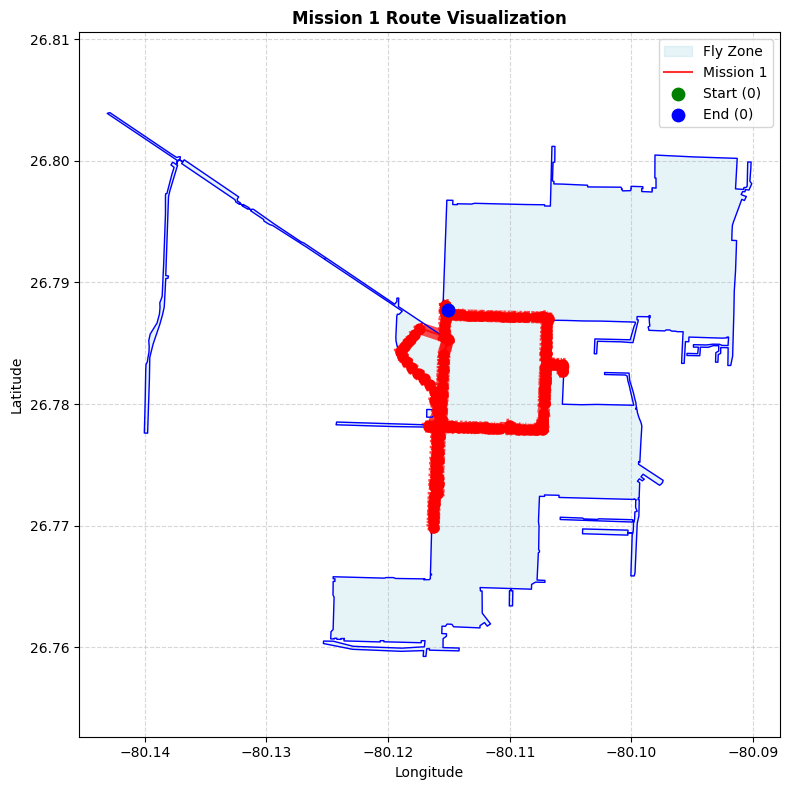



Mission - 2
Nodes Left: 2206
Visited Nodes: 295
Route: [0, 1047, 1044, 1045, 1046, 2667, 2668, 2683, 2684, 2675, 2676, 2703, 2704, 2679, 2680, 2699, 2691, 2692, 2707, 2708, 2711, 2712, 2715, 2716, 2631, 2632, 909, 908, 906, 905, 904, 910, 2627, 2628, 2619, 2620, 2635, 2636, 2615, 2616, 2623, 2624, 2731, 2734, 2733, 2732, 1539, 1538, 1555, 1537, 1552, 1553, 1554, 1544, 1547, 1546, 1545, 1540, 1543, 1542, 1551, 1541, 1548, 1549, 1572, 1550, 1575, 1574, 1573, 1576, 1579, 1578, 1577, 1568, 1571, 1570, 1569, 1564, 1567, 1566, 1565, 1560, 1563, 1562, 1561, 1687, 1690, 1689, 1688, 1556, 1559, 1558, 1557, 1652, 1655, 1654, 1653, 1648, 1656, 1651, 1659, 1658, 1650, 1657, 1649, 1644, 1647, 1646, 1645, 1691, 1694, 1693, 1692, 1636, 1639, 1632, 1635, 1628, 1631, 1679, 1682, 1667, 1670, 1624, 1627, 1671, 1620, 1674, 1623, 1663, 1666, 1616, 1619, 1675, 1678, 1612, 1615, 1608, 1611, 1604, 1607, 1600, 1603, 1596, 1599, 1592, 1595, 1660, 1662, 1580, 1583, 1588, 1591, 1584, 1587, 1586, 1585, 1590, 158

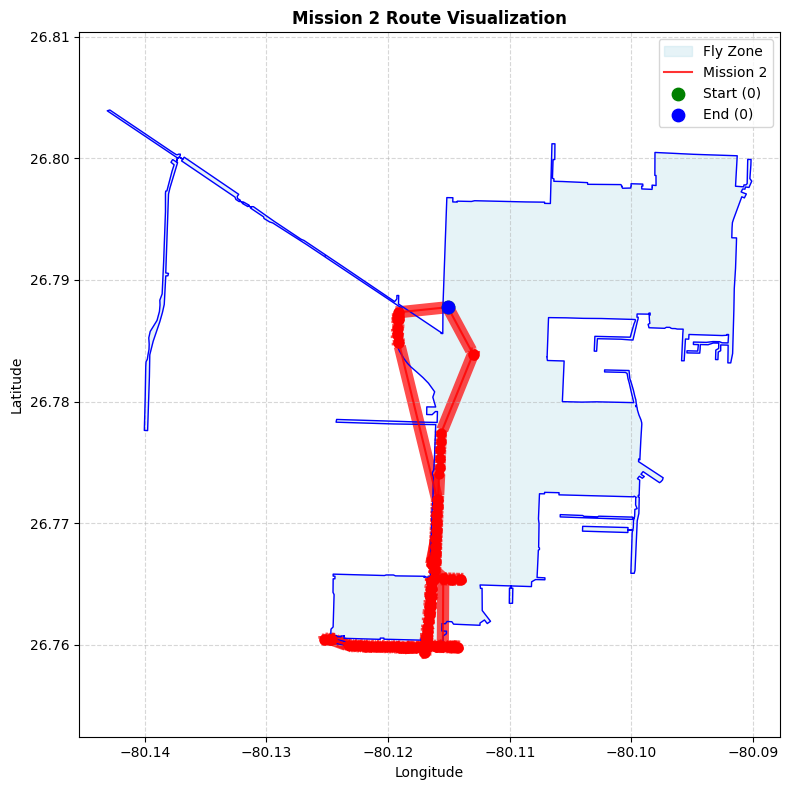



Mission - 3
Nodes Left: 1911
Visited Nodes: 405
Route: [0, 2355, 2354, 2348, 2324, 2351, 2327, 2280, 2283, 2448, 2451, 2276, 2279, 2278, 2277, 2450, 2449, 2282, 2281, 2326, 2350, 2325, 2349, 2443, 2442, 2347, 2346, 2343, 2342, 2339, 2338, 2335, 2334, 2323, 2322, 2331, 2330, 2439, 2438, 2435, 2434, 2379, 2378, 2371, 2370, 2431, 2430, 2367, 2366, 2363, 2362, 2361, 2360, 2365, 2364, 2429, 2428, 2369, 2368, 2377, 2376, 2433, 2432, 2437, 2436, 2329, 2328, 2321, 2320, 2333, 2332, 2337, 2336, 2341, 2340, 2345, 2344, 2441, 2440, 2445, 2446, 2447, 2444, 2353, 2352, 1962, 1961, 1966, 1965, 2010, 2009, 2014, 2018, 2017, 1970, 1969, 1974, 1973, 1978, 1977, 1994, 1993, 1986, 1985, 1982, 1981, 1990, 1989, 1998, 1997, 2022, 2021, 2026, 2025, 2030, 2029, 2270, 2271, 2266, 2267, 2258, 2259, 2262, 2247, 2246, 2243, 2242, 2213, 2216, 2217, 2236, 2237, 2224, 2225, 2232, 2233, 2228, 2229, 2220, 2221, 2208, 2209, 2204, 2205, 2200, 2201, 2196, 2197, 2192, 2193, 2188, 2189, 2180, 2181, 2182, 2183, 2190, 219

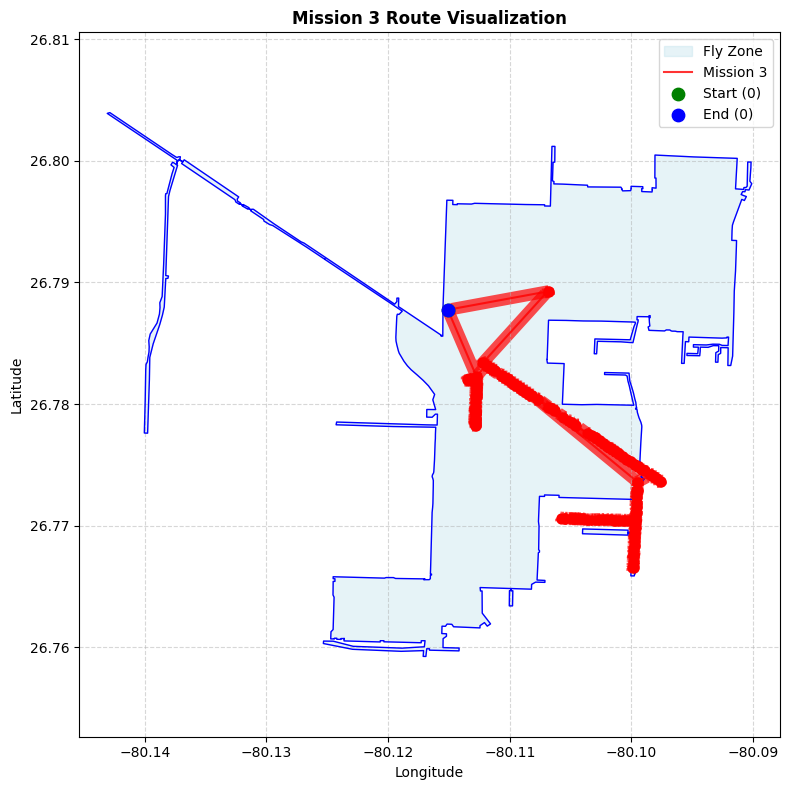



Mission - 4
Nodes Left: 1506
Visited Nodes: 449
Route: [0, 1832, 1831, 1834, 1835, 1836, 1833, 1816, 1817, 1818, 1815, 1838, 1839, 1840, 1837, 1842, 1843, 1844, 1841, 1846, 1847, 1848, 1845, 1813, 1812, 1811, 1854, 1859, 1850, 1855, 1814, 1851, 1852, 1856, 1849, 1863, 1864, 1861, 1862, 1860, 1853, 1857, 1858, 836, 837, 834, 835, 840, 841, 838, 839, 844, 845, 842, 843, 902, 903, 900, 901, 848, 849, 846, 847, 898, 899, 896, 897, 852, 853, 850, 851, 856, 857, 854, 855, 860, 861, 858, 859, 894, 895, 892, 893, 890, 891, 888, 889, 865, 864, 887, 886, 885, 884, 863, 862, 873, 872, 871, 870, 165, 166, 169, 170, 173, 174, 177, 178, 114, 115, 110, 111, 122, 123, 124, 125, 126, 127, 129, 128, 95, 94, 91, 90, 87, 86, 99, 98, 103, 102, 436, 435, 438, 437, 105, 104, 101, 100, 89, 88, 93, 92, 97, 96, 130, 119, 118, 121, 120, 117, 116, 112, 109, 106, 134, 131, 138, 135, 142, 139, 146, 143, 150, 147, 148, 149, 144, 145, 140, 141, 136, 137, 132, 133, 107, 108, 113, 175, 176, 171, 172, 167, 168, 163, 1

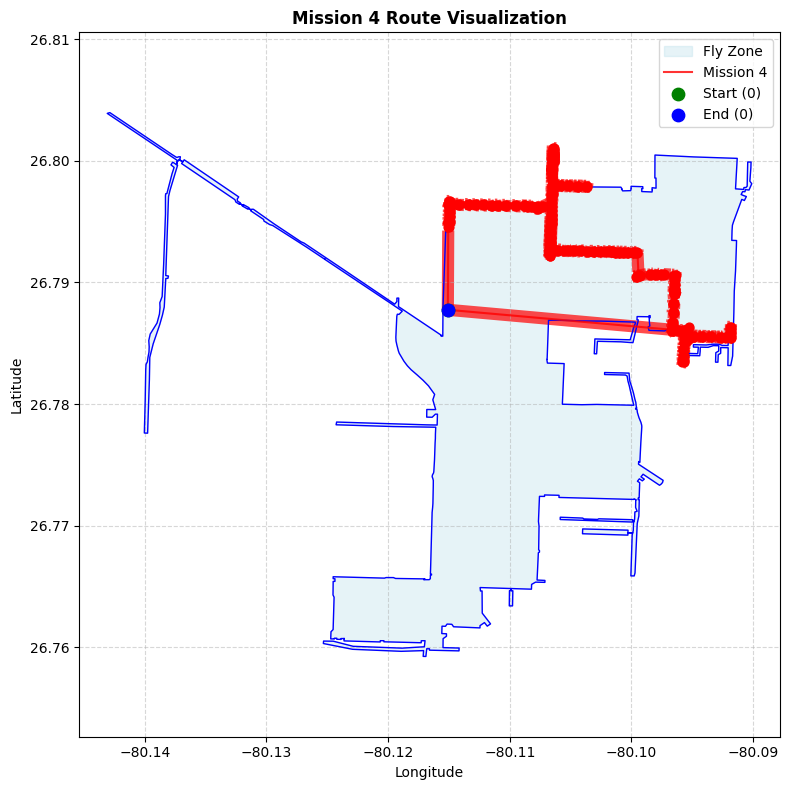



Mission - 5
Nodes Left: 1057
Visited Nodes: 291
Route: [0, 396, 397, 398, 395, 400, 401, 402, 399, 404, 405, 406, 403, 408, 409, 410, 407, 412, 413, 414, 411, 308, 309, 310, 307, 312, 313, 314, 311, 316, 317, 318, 315, 320, 321, 322, 319, 324, 333, 325, 326, 334, 323, 332, 337, 336, 341, 340, 349, 348, 345, 344, 441, 440, 353, 352, 357, 356, 445, 444, 361, 360, 365, 364, 369, 368, 373, 372, 371, 374, 367, 370, 363, 366, 359, 362, 443, 446, 355, 358, 351, 354, 439, 442, 343, 346, 347, 350, 339, 342, 335, 338, 331, 328, 329, 330, 327, 420, 421, 422, 425, 419, 424, 423, 426, 216, 217, 218, 215, 180, 428, 181, 429, 182, 430, 434, 874, 875, 878, 877, 876, 867, 879, 868, 869, 866, 882, 883, 880, 881, 207, 210, 209, 208, 211, 214, 213, 212, 528, 527, 526, 525, 532, 531, 530, 529, 671, 672, 667, 668, 675, 676, 495, 491, 492, 487, 488, 483, 484, 479, 480, 475, 476, 477, 474, 481, 478, 485, 482, 489, 486, 493, 490, 496, 494, 673, 674, 665, 666, 669, 670, 536, 535, 534, 533, 568, 567, 566, 565,

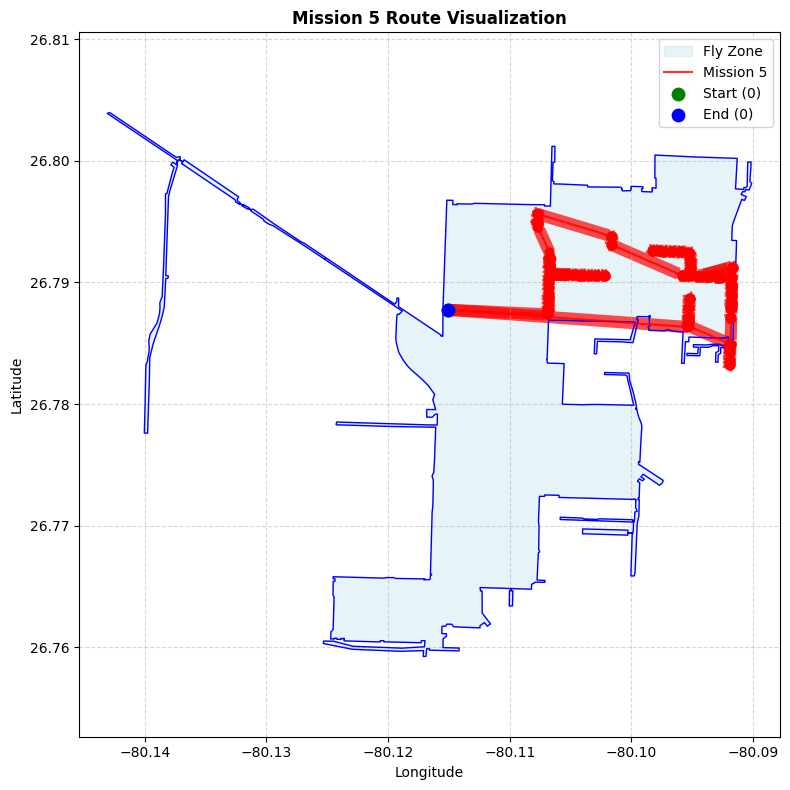



Mission - 6
Nodes Left: 766
Visited Nodes: 298
Route: [0, 1004, 1007, 1006, 1005, 920, 923, 922, 921, 916, 919, 918, 917, 924, 927, 926, 925, 912, 915, 914, 913, 907, 911, 1022, 1023, 1020, 1021, 2746, 2745, 2744, 2743, 2757, 2758, 2755, 2756, 2754, 2753, 2752, 2751, 2765, 2766, 2763, 2764, 2762, 2761, 2760, 2759, 2773, 2774, 2771, 2772, 2778, 2777, 2776, 2775, 2769, 2770, 2767, 2768, 1314, 1313, 1316, 1317, 1318, 1315, 1298, 1299, 1300, 1297, 1290, 1291, 1292, 1289, 1294, 1295, 1296, 1293, 1302, 1303, 1304, 1301, 1306, 1307, 1308, 1305, 1310, 1311, 1312, 1309, 1320, 1321, 1322, 1319, 1396, 1397, 1398, 1395, 1453, 1454, 1455, 1452, 1461, 1462, 1463, 1460, 1336, 1335, 1334, 1333, 1332, 1331, 1457, 1458, 1459, 1456, 1399, 1400, 1401, 1464, 1465, 1466, 1467, 1468, 1469, 1470, 1471, 1535, 1536, 1472, 1473, 1474, 1475, 1476, 1477, 1478, 1481, 1479, 1482, 1480, 1345, 1346, 1485, 1486, 1483, 1484, 1343, 1344, 1349, 1350, 1347, 1348, 1434, 1435, 1432, 1354, 1433, 1353, 1352, 1351, 1357, 1356

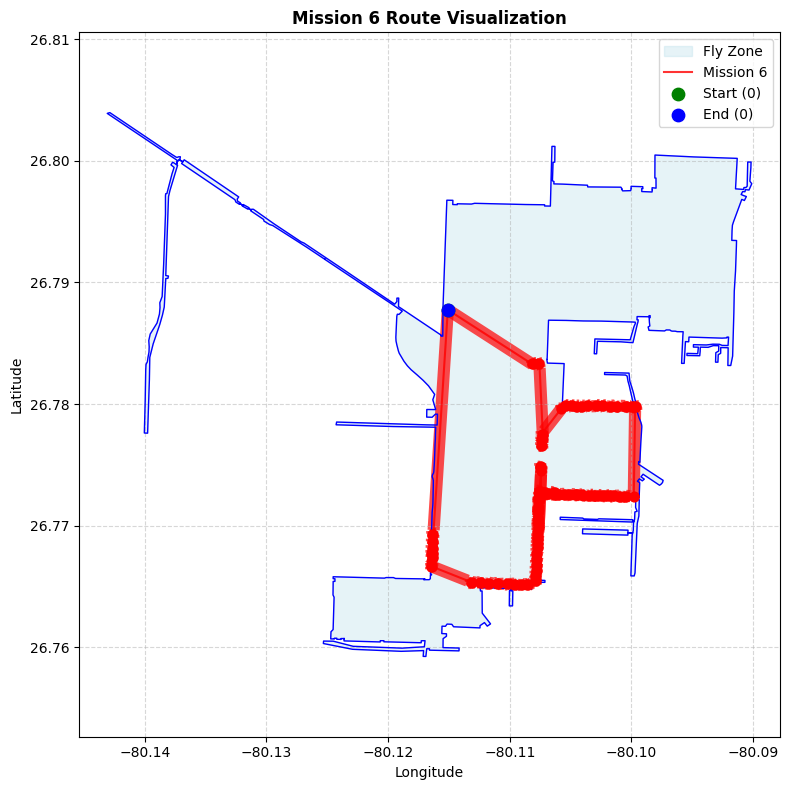



Mission - 7
Nodes Left: 468
Visited Nodes: 78
Route: [0, 1515, 1518, 1517, 1516, 1511, 1514, 1513, 1512, 1507, 1510, 1509, 1508, 1503, 1506, 1505, 1504, 1338, 1337, 1499, 1502, 1501, 1500, 1495, 1498, 1497, 1496, 1491, 1494, 1493, 1492, 1490, 1487, 1488, 1489, 1450, 1451, 1341, 1342, 1339, 1340, 1448, 1449, 2184, 2185, 2186, 2187, 1940, 1943, 1944, 1947, 1936, 1939, 1948, 1952, 1951, 1955, 1954, 1950, 1953, 1949, 1938, 1937, 1946, 1945, 1942, 1941, 1389, 1388, 1387, 1390, 1438, 1437, 1436, 1441, 1439, 1442, 1443, 1440, 0]


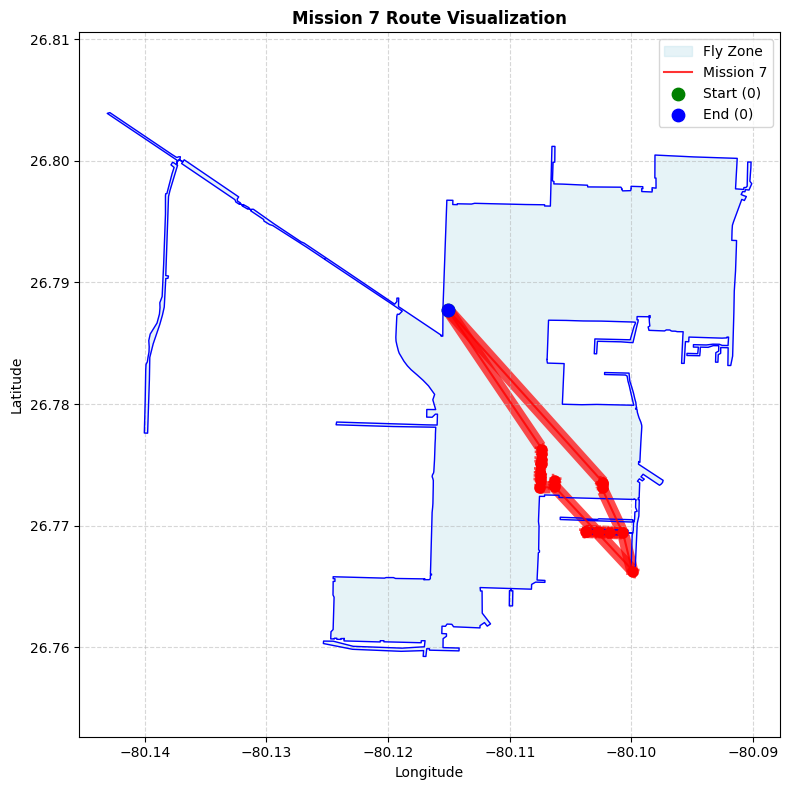



Mission - 8
Nodes Left: 390
Visited Nodes: 129
Route: [0, 2061, 2060, 2063, 2068, 2064, 2067, 2056, 2059, 2048, 2051, 2040, 2043, 2044, 2047, 2052, 2055, 2072, 2075, 2036, 2039, 2032, 2035, 2476, 2142, 2143, 2162, 2163, 2136, 2137, 2133, 2134, 2140, 2141, 2161, 2160, 2093, 2092, 2091, 2090, 2089, 2088, 2087, 2086, 2085, 2084, 2083, 2168, 2169, 2170, 2171, 2154, 2155, 2172, 2173, 2150, 2151, 2152, 2153, 2174, 2175, 2156, 2157, 2167, 2166, 2159, 2158, 2135, 2138, 2139, 2164, 2165, 2144, 2145, 2477, 2453, 2454, 2457, 2460, 2463, 2466, 2473, 2485, 2482, 2479, 2480, 2478, 2483, 2481, 2486, 2484, 2474, 2472, 2467, 2465, 2464, 2462, 2461, 2459, 2458, 2456, 2455, 2452, 2471, 2468, 2469, 2470, 2475, 2034, 2033, 2038, 2037, 2074, 2073, 2054, 2053, 2046, 2045, 2042, 2041, 2050, 2049, 2058, 2057, 2066, 2065, 2071, 2070, 2069, 2062, 0]


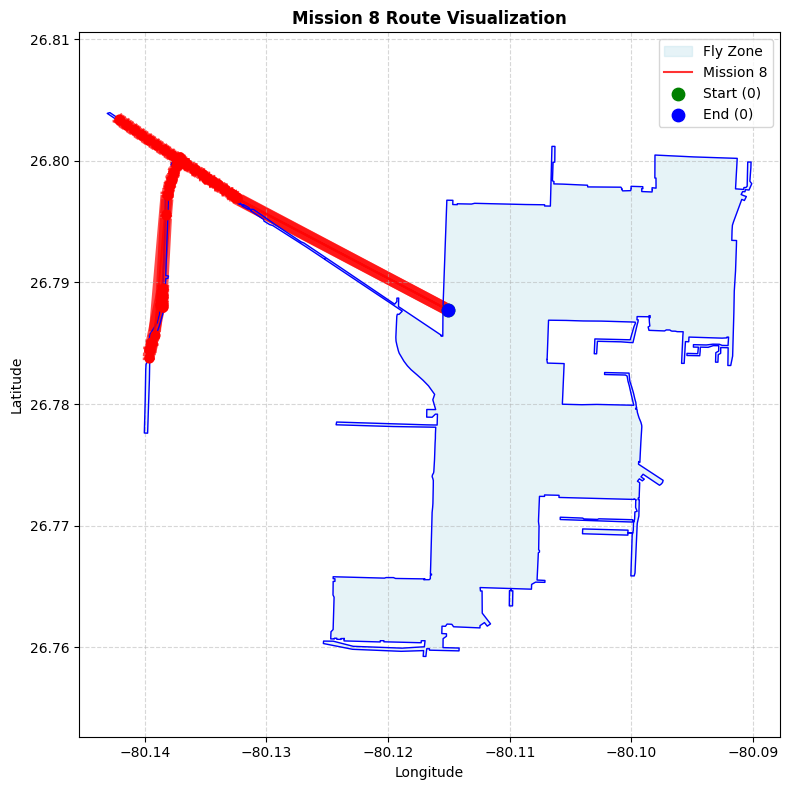



Mission - 9
Nodes Left: 261
Visited Nodes: 212
Route: [0, 711, 712, 709, 816, 710, 815, 814, 813, 812, 811, 810, 809, 716, 715, 714, 719, 713, 720, 717, 732, 718, 731, 730, 729, 736, 829, 735, 828, 734, 827, 733, 826, 747, 748, 745, 746, 751, 752, 749, 750, 686, 687, 688, 685, 690, 691, 692, 689, 694, 693, 696, 695, 698, 699, 700, 697, 702, 703, 704, 701, 707, 706, 705, 708, 819, 818, 817, 820, 806, 807, 808, 805, 658, 659, 660, 657, 663, 662, 661, 654, 653, 646, 645, 642, 641, 650, 649, 1777, 1772, 1773, 1768, 1769, 1764, 1765, 1760, 1761, 1756, 1757, 1792, 1793, 1784, 1785, 1752, 1753, 1748, 1749, 1728, 1729, 1724, 1719, 1720, 1721, 1722, 1708, 1709, 1712, 1713, 1714, 1705, 1700, 1701, 1696, 1025, 1037, 1036, 1039, 1032, 1028, 1035, 1031, 1030, 1034, 1029, 1033, 1038, 1026, 1027, 1024, 1697, 1698, 1695, 1702, 1699, 1706, 1703, 1704, 1711, 1710, 1707, 1717, 1718, 1715, 1716, 1725, 1726, 1723, 1730, 1727, 1750, 1747, 1754, 1751, 1786, 1783, 1794, 1791, 1758, 1755, 1762, 1759, 1789, 1

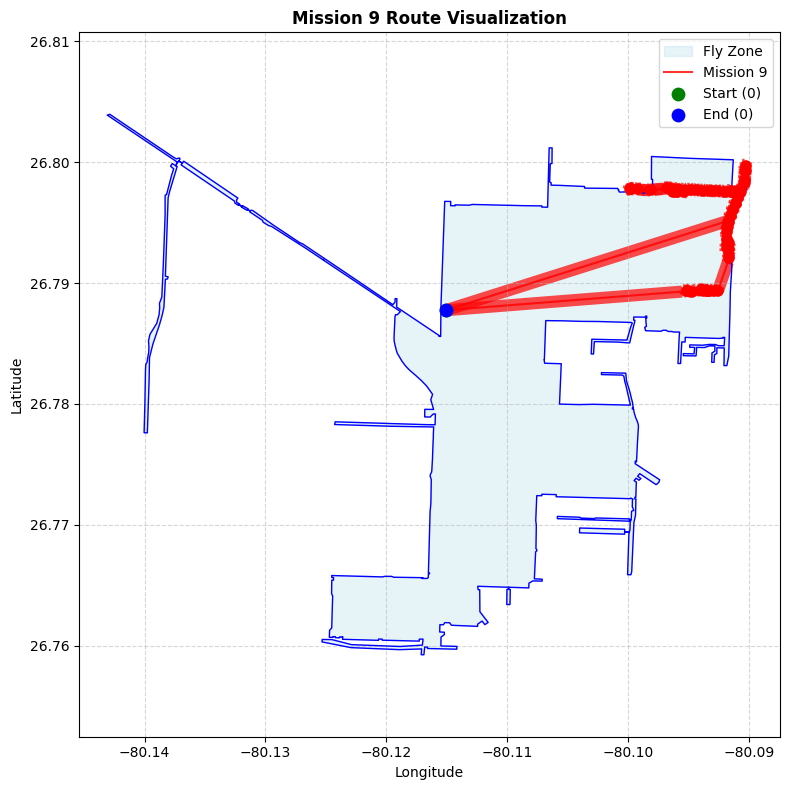



Mission - 10
Nodes Left: 49
Visited Nodes: 41
Route: [0, 2147, 2146, 2132, 2131, 2130, 2129, 2128, 2127, 2126, 2125, 2124, 2123, 2122, 2121, 2120, 2119, 2118, 2117, 2116, 2115, 2114, 2113, 2112, 2111, 2110, 2109, 2108, 2107, 2106, 2105, 2104, 2103, 2102, 2101, 2100, 2099, 2098, 2097, 2096, 2095, 2094, 0]


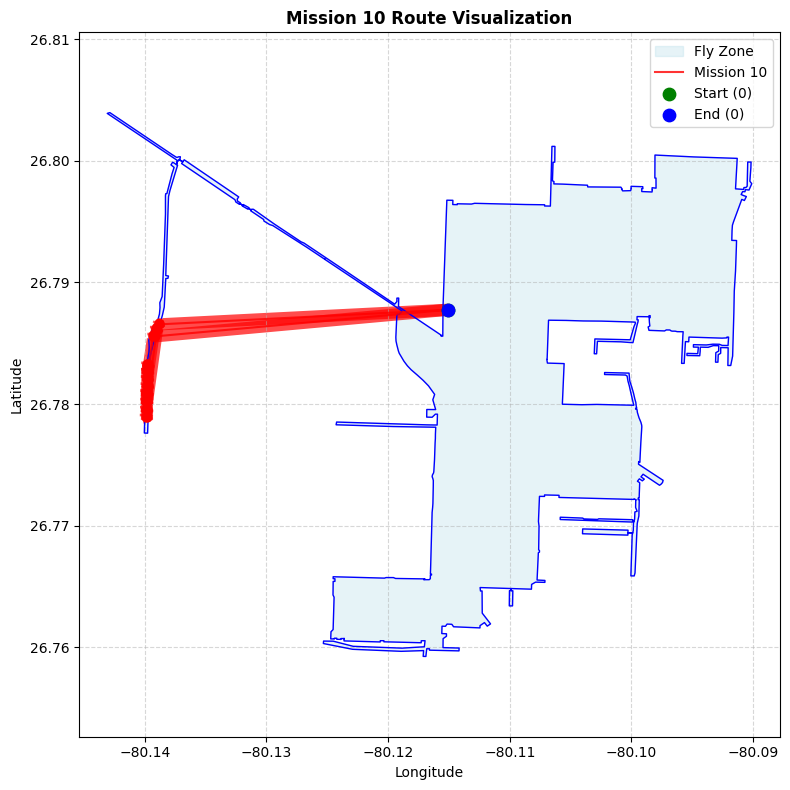



Mission - 11
Nodes Left: 8
Visited Nodes: 6
Route: [0, 2176, 2177, 2148, 2149, 2178, 2179, 0]


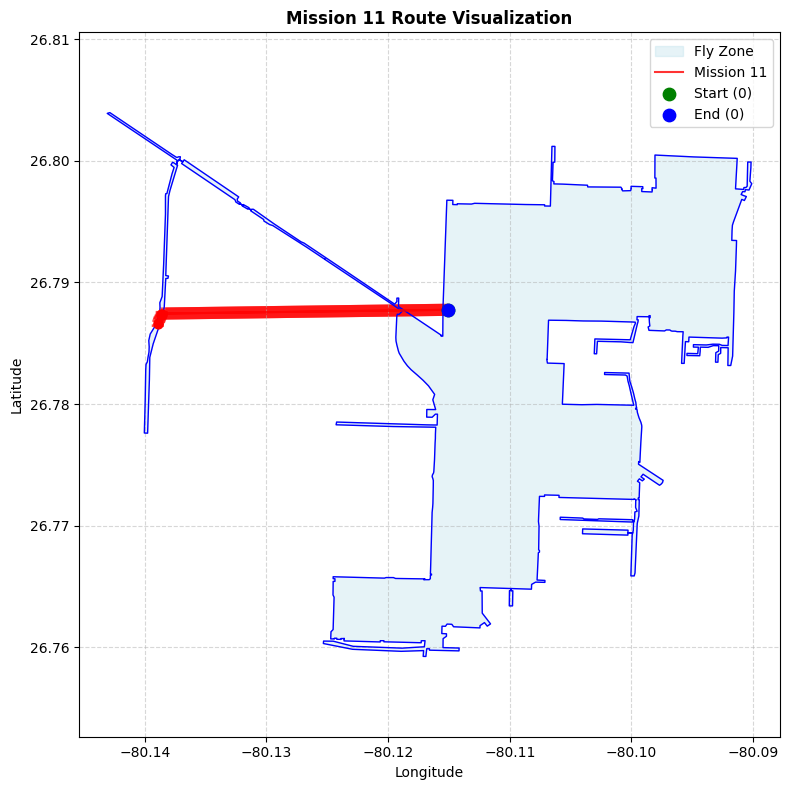



Mission - 12
Nodes Left: 2
Visited Nodes: 2
Route: [0, 2274, 2275, 0]


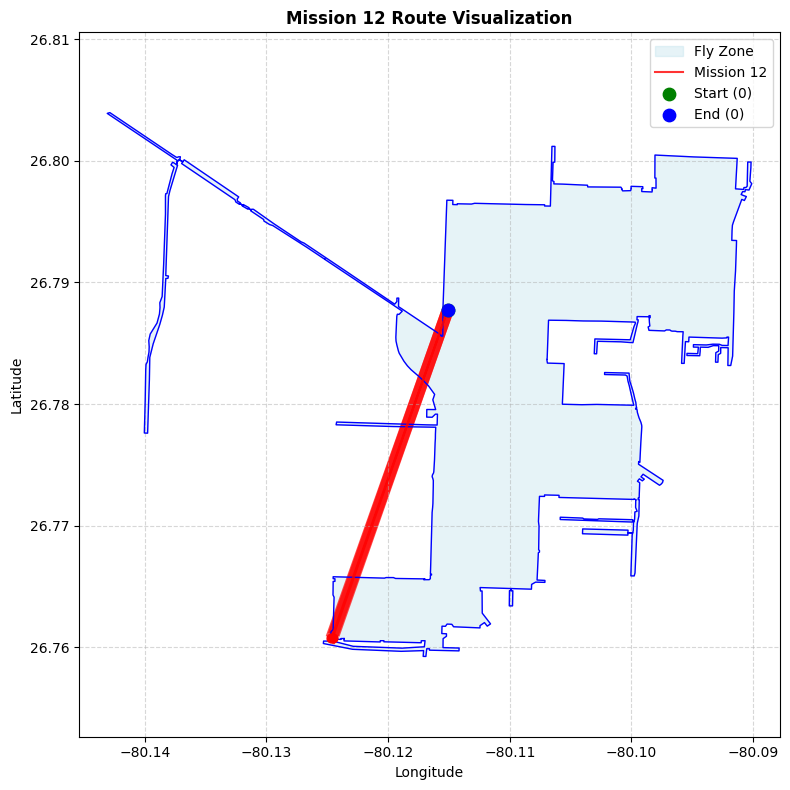

Total Number of Missions: 12
Total Number of Nodes Visited: 2778
Total Number of Nodes Left to visit: 0
Total distance travelled: 410899.0


In [21]:
main()

In [ ]:
# [
# mission_time - [10,  20,  30,  40,  50,  60,  70,  80,  90,  100,  110,  120]
# total_distance - [406605.0,  383160.0,  381606.0,  381823.0,  380770.0,  377158.0,  377131.0,  376523.0,  385868.0,  384845.0,  388482.0,  380787.0]
# number_of_missions - [12,  12,  11,  11,  11,  11,  11,  11,  11,  11,  11,  11]
# ]

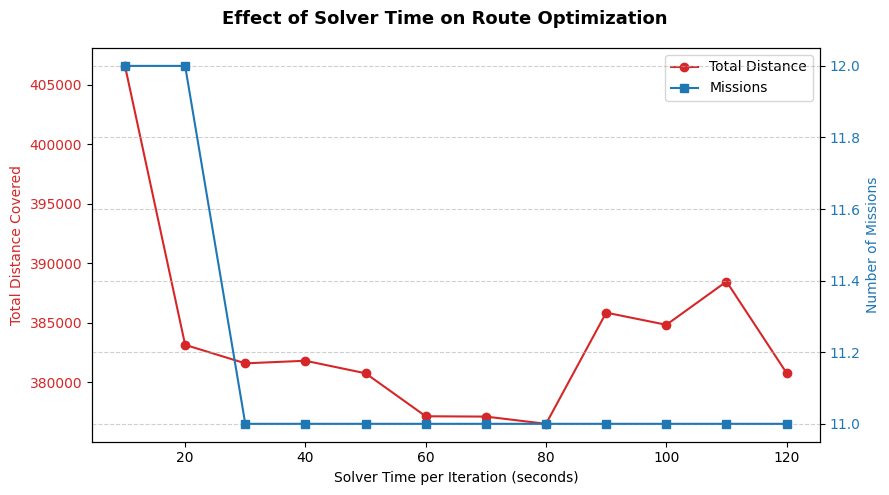

In [13]:
# Data
mission_time = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]
total_distance = [406605.0, 383160.0, 381606.0, 381823.0, 380770.0, 377158.0,
                  377131.0, 376523.0, 385868.0, 384845.0, 388482.0, 380787.0]
number_of_missions = [12, 12, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]

# Create figure
fig, ax1 = plt.subplots(figsize=(9, 5))

# Plot total distance (left axis)
color = 'tab:red'
ax1.set_xlabel('Solver Time per Iteration (seconds)')
ax1.set_ylabel('Total Distance Covered', color=color)
ax1.plot(mission_time, total_distance, '-o', color=color, label='Total Distance')
ax1.tick_params(axis='y', labelcolor=color)

# Create second y-axis for missions
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Number of Missions', color=color)
ax2.plot(mission_time, number_of_missions, '-s', color=color, label='Missions')
ax2.tick_params(axis='y', labelcolor=color)

# Styling
fig.suptitle('Effect of Solver Time on Route Optimization', fontsize=13, weight='bold')
fig.tight_layout()
plt.grid(True, linestyle='--', alpha=0.6)

# Add combined legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='best')

plt.show()
